# Training parameterized quantum circuits

## Vocab
+ Minimize <phi(theta)|H|phi(theta)> (this is the loss function)
+ Quantum Fisher Information (Natural Gradients)
+ Simultaneous Perturbation Stochastic Approximation

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear')
# RealAmplitudes -> TwoLocal -> NLocal -> BlueprintCircuit -> QuantumCircuit
print(ansatz.draw())
ansatz = ansatz.decompose()
ansatz.draw()

     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘


┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

# Opflow

## Calculate finite difference gradient

In [2]:
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, Z, I

hamiltonian = Z ^ Z
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    # print(result)
    return np.real(result)

print(ansatz.num_parameters)
point = np.random.random(ansatz.num_parameters)
INDEX = 2

EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]
print(e_i)

plus = point + EPS * e_i
minus = point - EPS * e_i

print(plus)
print(minus)

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3630295614.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, Z, I
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3630295614.py:7: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3630295614.py:7: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be remo

4
[0. 0. 1. 0.]
[0.07911622 0.744337   0.59847008 0.12734039]
[0.07911622 0.744337   0.19847008 0.12734039]
(0.5246582031250001+0j)
(0.62548828125+0j)
-0.2520751953124997


C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3630295614.py:10: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3630295614.py:14: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(quantum_instance)


## Calculate with Qiskit gradient

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3128319237.py:3: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)


ansatz params : ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])])
ansatz params element : θ[2]
grad : SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])
value dict : {ParameterVectorElement(θ[0]): 0.07911621650354528, ParameterVectorElement(θ[1]): 0.7443370039719708, ParameterVectorElement(θ[2]): 0.3984700793584436, ParameterVectorElem

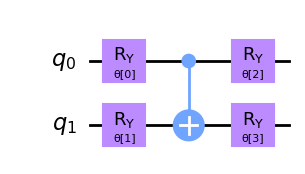

In [3]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)

grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print("ansatz params : %s" % (ansatz.parameters))
print("ansatz params element : %s" % (ansatz.parameters[INDEX]))
print("grad : %s" %(grad)) # grad object contain the info of which param to optimize already

value_dict = dict(zip(ansatz.parameters, point))
print("value dict : %s" % (value_dict))

sampler.convert(grad, value_dict).eval().real

ansatz.bind_parameters([0,0,0,0])
ansatz.draw('mpl') # in order to be displayed correctly it need to be at the end of the line, this is possible thanks to matplotlib_inline
# this doesn't bind the value to the image

## Optimizer 

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3141079463.py:5: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  gradient = Gradient().convert(expectation)
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3141079463.py:6: DeprecationWarning: The class ``qiskit.opflow.expectations.pauli_expectation.PauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  gradient_in_pauli_basis = PauliExpectation().convert(gradient)
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3141079463.py:7: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earl

(0.880859375+0j)
(0.8779296875+0j)
(0.87744140625+0j)
(0.8747558593750001+0j)
(0.8723144531249999+0j)
(0.8703613281250001+0j)
(0.8664550781249999+0j)
(0.8635253906249999+0j)
(0.8605957031249999+0j)
(0.85693359375+0j)
(0.8540039062499999+0j)
(0.8537597656250001+0j)
(0.849609375+0j)
(0.84521484375+0j)
(0.8422851562499999+0j)
(0.8383789062500001+0j)
(0.8356933593750001+0j)
(0.8330078125+0j)
(0.8293457031249999+0j)
(0.8249511718750001+0j)
(0.8200683593749999+0j)
(0.81591796875+0j)
(0.8125000000000001+0j)
(0.8083496093750001+0j)
(0.8034667968750001+0j)
(0.7978515625+0j)
(0.7917480468750001+0j)
(0.787109375+0j)
(0.78076171875+0j)
(0.7753906249999999+0j)
(0.7702636718749999+0j)
(0.7658691406249999+0j)
(0.7595214843750001+0j)
(0.7548828125+0j)
(0.74853515625+0j)
(0.7421875+0j)
(0.7351074218750001+0j)
(0.7304687499999999+0j)
(0.72607421875+0j)
(0.7180175781249999+0j)
(0.7145996093750001+0j)
(0.7070312499999999+0j)
(0.7014160156249999+0j)
(0.6936035156249999+0j)
(0.6865234375+0j)
(0.680664062500

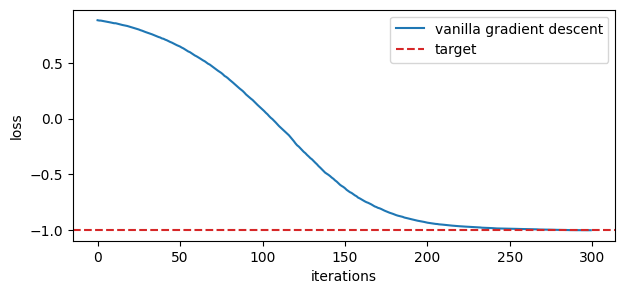

In [4]:
# initial_point = np.random.random(ansatz.num_parameters)
# Initialize 
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## Natural gradient

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\1881150701.py:2: DeprecationWarning: The class ``qiskit.opflow.gradients.natural_gradient.NaturalGradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  natural_gradient = (NaturalGradient(regularization='ridge')
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\1881150701.py:5: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(quantum_instance, caching="all")


Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587408 -0.86456928 -0.98085959 -0.3382013 ]
(0.8757324218750001+0j)
(0.8693847656249999+0j)
(0.8623046875000001+0j)
(0.8537597656249999+0j)
(0.8442382812500001+0j)
(0.8378906249999999+0j)
(0.8266601562499999+0j)
(0.8176269531249999+0j)
(0.8049316406249999+0j)
(0.79296875+0j)
(0.7819824218750001+0j)
(0.7692871093750001+0j)
(0.7529296875+0j)
(0.7375488281250001+0j)
(0.72216796875+0j)
(0.7067871093749999+0j)
(0.6921386718750001+0j)
(0.6760253906249999+0j)
(0.6601562500000001+0j)
(0.6433105468750001+0j)
(0.6291503906249999+0j)
(0.6145019531249999+0j)
(0.5986328125+0j)
(0.583984375+0j)
(0.5659179687500001+0j)
(0.5480957031249999+0j)
(0.5270996093749999+0j)
(0.5048828125+0j)
(0.4833984375+0j)
(0.45947265625+0j)
(0.432373046875+0j)
(0.40673828125+0j)
(0.380126953125+0j)
(0.3500976562499999+0j)
(0.31494140625+0j)
(0.28369140625+0j)
(0.250732421875+0j)
(0.21630859375000008+0j)
(0.179931640625+0j)
(0.1406

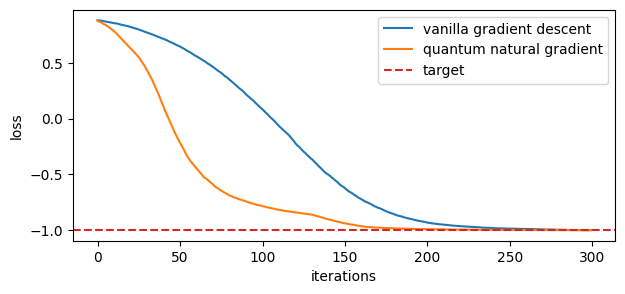

In [5]:
from qiskit.opflow import NaturalGradient
natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))

sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(natural_gradient, params=value_dict).eval()
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

qng_log = OptimizerLog()
qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_log.update)

result = qng.minimize(evaluate_expectation,
                      initial_point,
                      evaluate_natural_gradient)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## SPSA

(0.8781738281249999+0j)
(0.8879394531249999+0j)
(0.880859375+0j)
(0.8820800781249999+0j)
(0.8793945312499999+0j)
(0.8806152343750001+0j)
(0.8762207031249999+0j)
(0.8845214843750001+0j)
(0.87841796875+0j)
(0.8737792968750001+0j)
(0.8825683593749999+0j)
(0.876953125+0j)
(0.8703613281249999+0j)
(0.8818359375+0j)
(0.8747558593749999+0j)
(0.8666992187500001+0j)
(0.8771972656249999+0j)
(0.8693847656250001+0j)
(0.8681640625+0j)
(0.87353515625+0j)
(0.8681640625+0j)
(0.8757324218749999+0j)
(0.8649902343750001+0j)
(0.8674316406249999+0j)
(0.8598632812499999+0j)
(0.8730468749999999+0j)
(0.8620605468750001+0j)
(0.8515624999999999+0j)
(0.8730468750000001+0j)
(0.8510742187499999+0j)
(0.8527832031249999+0j)
(0.8530273437500001+0j)
(0.8513183593749999+0j)
(0.8503417968749999+0j)
(0.85498046875+0j)
(0.8518066406249999+0j)
(0.8559570312500001+0j)
(0.8459472656249999+0j)
(0.8486328124999999+0j)
(0.8474121093750001+0j)
(0.8500976562500001+0j)
(0.8491210937499999+0j)
(0.8503417968750001+0j)
(0.845947265624

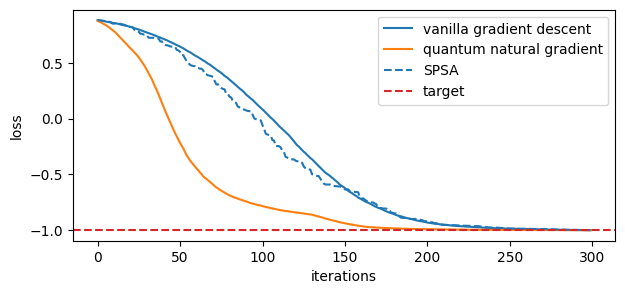

In [6]:
from qiskit_algorithms.optimizers import SPSA
spsa_log = OptimizerLog()
spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_log.update)

result = spsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## QN-SPSA

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\259194994.py:5: DeprecationWarning: The class ``qiskit.opflow.expectations.pauli_expectation.PauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation=PauliExpectation())
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\259194994.py:3: DeprecationWarning: ``qiskit.algorithms.optimizers.qnspsa.QNSPSA.get_fidelity()``'s argument ``backend`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. See https://qisk.it/algo_migration for a migration guide.
  fidelity = QNSPSA.get_fidelity(ansatz,


(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8837890625+0j)
(0.8825683593750001+0j)
(0.8850097656249999+0j)
(0.88427734375+0j)
(0.8886718750000001+0j)
(0.876953125+0j)
(0.8776855468750001+0j)
(0.8835449218749999+0j)
(0.8728027343750001+0j)
(0.8759765624999999+0j)
(0.8825683593750001+0j)
(0.8706054687499999+0j)
(0.8657226562499999+0j)
(0.8601074218750001+0j)
(0.8681640625+0j)
(0.8540039062499999+0j)
(0.8571777343750001+0j)
(0.8535156249999999+0j)
(0.8554687500000001+0j)
(0.8532714843750001+0j)
(0.8608398437499999+0j)
(0.8547363281249999+0j)
(0.8547363281249999+0j)
(0.85498046875+0j)
(0.

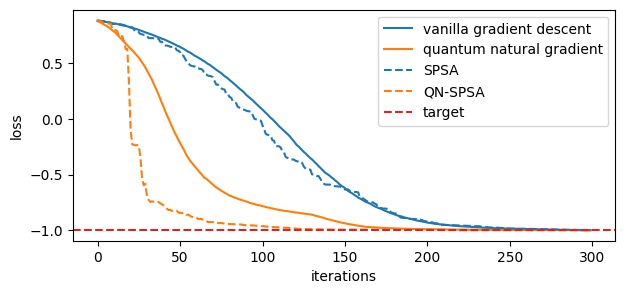

In [8]:
from qiskit.algorithms.optimizers import QNSPSA
qnspsa_log = OptimizerLog()
fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_log.update)

result = qnspsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## QN-SPSA with decreasing learning rate 

(0.8806152343750001+0j)
(0.9089355468749999+0j)
(0.7841796875+0j)
(0.8962402343750001+0j)
(0.6066894531249999+0j)
(0.9895019531249999+0j)
(0.97802734375+0j)
(0.7355957031249999+0j)
(0.8579101562499999+0j)
(0.6740722656249999+0j)
(0.74755859375+0j)
(0.8166503906249999+0j)
(0.7841796875+0j)
(0.8962402343750001+0j)
(0.9138183593750001+0j)
(0.7939453125+0j)
(0.943359375+0j)
(0.74853515625+0j)
(0.74853515625+0j)
(0.943359375+0j)
(0.7355957031249999+0j)
(0.97802734375+0j)
(0.97802734375+0j)
(0.7355957031249999+0j)
(0.8579101562499999+0j)
(0.6740722656249999+0j)
(0.6740722656249999+0j)
(0.8579101562499999+0j)
(0.74853515625+0j)
(0.943359375+0j)
(0.7939453125+0j)
(0.9138183593750001+0j)
(0.7355957031249999+0j)
(0.97802734375+0j)
(0.8166503906249999+0j)
(0.74755859375+0j)
(0.8579101562499999+0j)
(0.6740722656249999+0j)
(0.7939453125+0j)
(0.9138183593750001+0j)
(0.8579101562499999+0j)
(0.6740722656249999+0j)
(0.943359375+0j)
(0.74853515625+0j)
(0.8962402343750001+0j)
(0.7841796875+0j)
(0.8166503

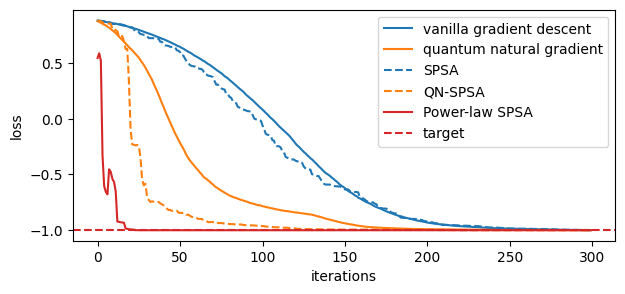

In [9]:
autospsa_log = OptimizerLog()
autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_log.update)

result = autospsa.minimize(evaluate_expectation, initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_log.loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_log.loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_log.loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_log.loss, 'C3', label='Power-law SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

## Limitations
barren plateau problem : vanishing gradient when circuit depth and width increase

In [10]:
from qiskit.opflow import I # I is the identity matrix

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.

    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits

    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])

    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads

### Global + linear depth

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:22: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(operator,
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:23: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  is_measurement=True).compose(StateFn(ansatz))
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:24: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the r

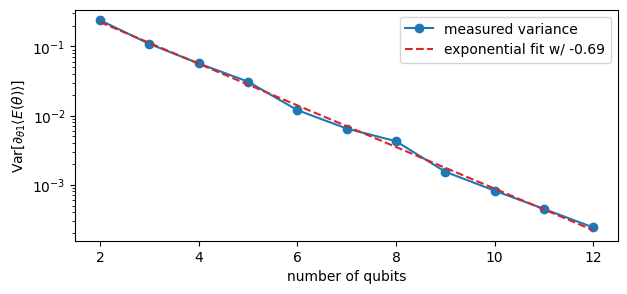

In [11]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
# np.polyfit returns a list of coefficent (in this case 2 because deg = 1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)
# 200 points equally spaced between num_qubits[0], num_qubits[-1]

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best')

### Global + constant depth

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:22: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(operator,
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:23: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  is_measurement=True).compose(StateFn(ansatz))
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:24: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the r

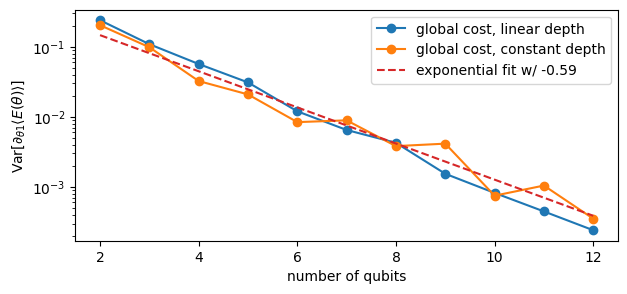

In [12]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best')

### Local + linear depth 

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:22: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(operator,
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:23: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  is_measurement=True).compose(StateFn(ansatz))
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\3017133303.py:24: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the r

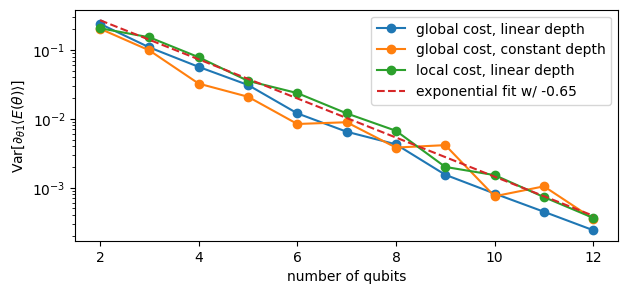

In [13]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n,
                                        local=True) for n in num_qubits]
fit = np.polyfit(num_qubits,
                 np.log(np.var(linear_depth_local_gradients,axis=1)),
                 deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1),
             'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1),
             'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best')

### Local + constant depth

In [14]:
NUM_QUBITS = 6
OPERATOR = Z ^ Z ^ (I ^ (NUM_QUBITS - 4))

def minimize(circuit, optimizer):
    """
    Args:
        circuit (QuantumCircuit): (Partially bound) ansatz circuit to train
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        OptimizerResult: Result of minimization
    """
    initial_point = np.random.random(circuit.num_parameters)

    exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)

    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(quantum_instance, caching="all")

    def loss(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(exp, values_dict).eval())

    def gradient(theta):
        values_dict = dict(zip(circuit.parameters, theta))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.minimize(loss, initial_point, gradient)

def layerwise_training(ansatz, max_num_layers, optimizer):
    """
    Args:
        ansatz (QuantumCircuit): Single circuit layer to train & repeat
        max_num_layers (int): Maximum number of layers
        optimizer (Optimizer): Algorithm to use to minimize exp. value
    Returns:
        float: Lowest value acheived
        list[float]: Best parameters found
    """
    optimal_parameters = []
    for reps in range(max_num_layers):
        ansatz.reps = reps

        # fix the already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)

        result = minimize(partially_bound, optimizer)
        optimal_parameters += list(result.x)
        print('Layer:', reps, ' Best Value:', result.fun)

    return result.fun, optimal_parameters

ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

np.random.seed(12)  # for reproducibility
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\1528871881.py:14: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\1528871881.py:14: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  exp = StateFn(OPERATOR, is_measurement=True) @ StateFn(circuit)
C:\Users\vutha\AppData\Local\Temp\ipykernel_18016\1528871881.py:15: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It wi

Layer: 0  Best Value: 0.6162109375
Layer: 1  Best Value: 0.25537109375000006
Layer: 2  Best Value: -0.12353515625
Layer: 3  Best Value: -0.546875


# Quantum_info & primitives & algo

Doc on how to use Estimator class: https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.Estimator.html 

## Test

In [ ]:
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Clifford

X = SparsePauliOp("X")

qc = QuantumCircuit(1)
qc.h(0)
H = Clifford(qc).to_operator()

plus = QuantumCircuit(1)
plus.h(0)

estimator = Estimator()
values_plus = estimator.run([plus, plus], [X, H]).result().values

print(values_plus)

## Gradient finite difference (manual)

In [ ]:
import numpy as np
from qiskit.quantum_info import Pauli
from qiskit_aer.primitives import Estimator

hamiltonian = Pauli('ZZ')

estimator = Estimator(run_options={"shots":8192, "seed_simulator":2718})
def evaluate_expectation(theta):
    result = estimator.run(ansatz, hamiltonian, theta).result().values
    # or we can set seed and shot like this 
    # result = estimator.run(ansatz, hamiltonian, theta, run_options={"shots":8192, "seed_simulator":2718}).result().values
    print(result)
    return np.real(result)

point = np.random.random(ansatz.num_parameters)
INDEX = 2

EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]
print(e_i)

plus = point + EPS * e_i
minus = point - EPS * e_i

print(plus)
print(minus)

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

## Qiskit gradient

In [ ]:
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

grad = ParamShiftEstimatorGradient(estimator)

print(ansatz.parameters)
print(hamiltonian)
print(point)

result = grad.run(ansatz, hamiltonian,[point], [ansatz.parameters[INDEX:INDEX+1]]).result()
# Argument parameter of function run:
# parameters: The sequence of parameters to calculate only the gradients of the specified parameters.

gradients = result.gradients
print(gradients)

## Optimizer

## Natural Gradient
doc for migration : https://qiskit.org/documentation/migration_guides/opflow_migration.html#gradients

Effect of Natural gradient can be achieved with QFI module

**QFI :** Quantum Fisher information (Regularizer) [doc](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.QFI.html#qiskit.algorithms.gradients.QFI)

**QGT :** Quantum Geometric Tensor (QGT) [doc](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.LinCombQGT.html)

### Intuition of QFI

+ Mathematically, the QFI is related to the second derivative of the quantum state's fidelity with respect to the parameter Θ. The fidelity measures the similarity between two quantum states and is a way to quantify how distinguishable they are.

+  QFI is a tool that helps you figure out how accurately you can make measurement. It's a number that tells you how much useful information you can get from your quantum system about what you're trying to measure.

In [ ]:
from qiskit_algorithms.gradients import LinCombQGT, QFI
import numpy as np

qgt = LinCombQGT(estimator)
qfi = QFI(qgt)

result = qfi.run(qc,[point])